## Sentitel 3 Data Extraction
This notebook converts L. Erie sensor locations to a convext hull and then extracts mean  sensor data for the area within that polygon for [Sentinel3]((https://explorer.earthengine.google.com/#detail/COPERNICUS%2FS3%2FOLCI) images within a set timeframe.

In [1]:
#Initialize ee
import ee
ee.Initialize()

In [2]:
#Import other packages
import pandas as pd
from IPython.display import Image

In [4]:
#Import the points as a feature collection (from Fusion table)
features = ee.FeatureCollection('ft:1eAIodIxPU1WPtp86DG3kuslS2bqUmCGtpR12lNpK');
print("{} features read".format(features.size().getInfo()))

24 features read


In [9]:
#Convert points to a convex hull
convexHull = features.geometry().convexHull()

In [121]:
#Buffer the points
bufferedPts = features.geometry().buffer(1000)

In [122]:
#Get the Sentinel3 image collection and filter it
images = (ee.ImageCollection('COPERNICUS/S3/OLCI')
          .filterBounds(bufferedPts)
          .filterDate('2017-09-01','2017-10-01'))
print("{} images retrieved".format(images.size().getInfo()))

30 images retrieved


In [123]:
#Construct a list of bands
bands = pd.DataFrame.from_dict(images.first().getInfo()['bands'])['id'].tolist()

In [34]:
#Get the first image and show it's thumb
scene = ee.Image(images.first())
Image(url=scene.getThumbURL({'bands':'Oa07_radiance','palette':'White,Green',
                             'min':0,
                             'max':800}))

* Reduce the image to the feature location(s)

In [124]:
data = images.getRegion(bufferedPts,300).getInfo()

In [125]:
#Data start at the second record in the getInfo() object with the 1st record as the column names
df = pd.DataFrame(data[1:],columns=data[0])
#Convert the time stamp to a date value
df['time'] = pd.to_datetime(df['time'],unit='ms')
df.head()

,id,longitude,latitude,time,Oa01_radiance,Oa02_radiance,Oa03_radiance,Oa04_radiance,Oa05_radiance,Oa06_radiance,...,Oa13_radiance,Oa14_radiance,Oa15_radiance,Oa16_radiance,Oa17_radiance,Oa18_radiance,Oa19_radiance,Oa20_radiance,Oa21_radiance,quality_flags
0,S3A_20170902T161541_20170902T161841,-82.22145,41.44692,2017-09-02 16:15:41,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,S3A_20170903T154930_20170903T155230,-82.22145,41.44692,2017-09-03 15:49:30,147.0,163.0,171.0,166.0,159.0,140.0,...,33.0,57.0,96.0,103.0,86.0,83.0,60.0,24.0,65.0,2.818572e+09
2,S3A_20170904T152319_20170904T152619,-82.22145,41.44692,2017-09-04 15:23:19,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,S3A_20170904T152619_20170904T152919,-82.22145,41.44692,2017-09-04 15:26:19,103.0,110.0,103.0,84.0,77.0,63.0,...,18.0,32.0,59.0,64.0,56.0,54.0,33.0,8.0,43.0,2.147484e+09
4,S3A_20170906T161157_20170906T161457,-82.22145,41.44692,2017-09-06 16:11:57,68.0,71.0,66.0,55.0,51.0,45.0,...,20.0,36.0,67.0,73.0,66.0,64.0,44.0,15.0,50.0,2.151678e+09


In [115]:
#Group on image, computing mean
df2 = df.groupby('time')[df.columns[4:]].median()
df2.head()

,Oa01_radiance,Oa02_radiance,Oa03_radiance,Oa04_radiance,Oa05_radiance,Oa06_radiance,Oa07_radiance,Oa08_radiance,Oa09_radiance,Oa10_radiance,...,Oa13_radiance,Oa14_radiance,Oa15_radiance,Oa16_radiance,Oa17_radiance,Oa18_radiance,Oa19_radiance,Oa20_radiance,Oa21_radiance,quality_flags
time,,,,,,,,,,,,,,,,,,,,,
2017-09-02 16:15:41,156.0,173.0,185.5,184.0,179.0,161.0,144.0,138.0,135.5,133.0,...,51.5,75.5,113.5,118.0,94.5,90.5,67.5,26.5,66.5,2.822767e+09
2017-09-03 15:49:30,87.0,92.5,88.5,81.0,78.0,73.0,59.0,52.5,49.5,49.0,...,10.5,18.5,31.0,33.0,21.0,18.5,13.0,4.5,13.5,2.684355e+09
2017-09-04 15:23:19,119.0,129.0,128.0,113.0,104.0,86.0,65.0,57.0,54.0,53.0,...,14.0,24.0,38.0,39.0,27.0,24.0,16.0,6.0,13.0,2.692743e+09
2017-09-04 15:26:19,117.0,126.0,123.0,106.0,98.0,80.0,61.0,51.0,49.0,48.0,...,13.0,22.0,38.0,39.0,28.0,26.0,18.0,6.0,18.0,2.692743e+09
2017-09-06 16:11:57,65.0,67.0,63.0,55.0,51.0,48.0,32.0,26.0,24.0,23.0,...,5.0,8.0,13.0,13.0,9.0,8.0,6.0,2.0,5.0,2.688549e+09


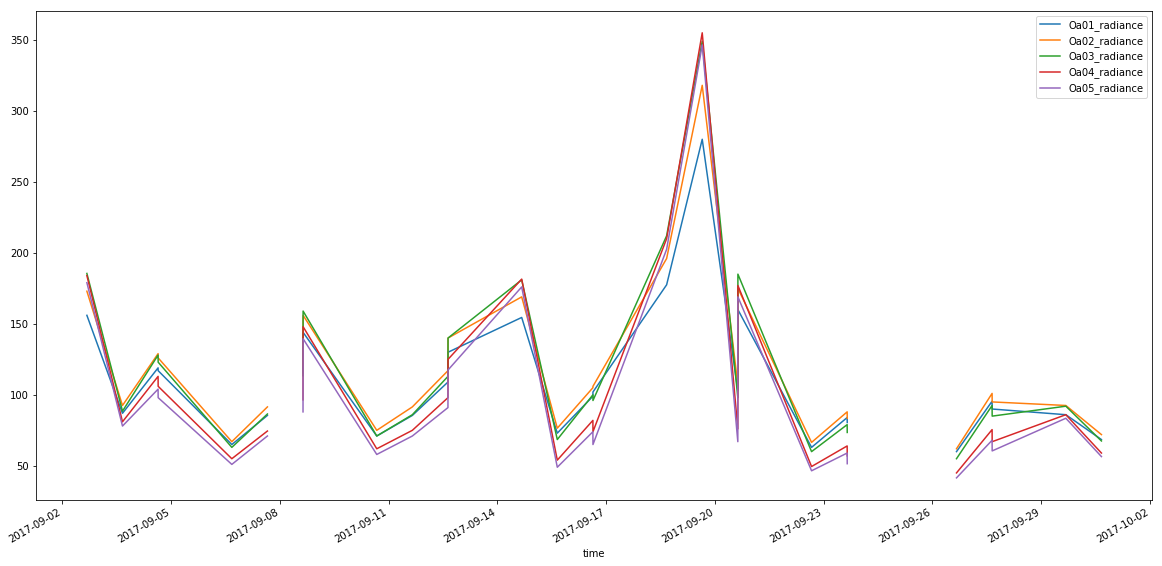

In [116]:
df2[bands[:5]].plot(figsize=(20,10));

In [109]:
df2.to_csv("../data/SentinelForArea1.csv")

In [117]:
df.to_csv("../data/SentinelForAreaAll1.csv",index=False)